# Hierarchical Attention Network for Document Classification

Use case: predicting Yelp ratings based on review text

Taken from: https://github.com/pandeykartikey/Hierarchical-Attention-Network/blob/master/HAN%20yelp.ipynb

In [7]:
import os
import re
import random
import pickle

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"  # check with nvidia-smi
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152

In [9]:
import unicodedata
import string
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
import pandas as pd
from bs4 import BeautifulSoup
import itertools
import more_itertools
import numpy as np


import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
## The dataset is taken from https://github.com/justmarkham/DAT7/blob/master/data/yelp.csv 
df = pd.read_csv('/Volumes/data/repo/data/yelp.csv')

In [11]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [12]:
# limit number of data for local development
df = df[:500]

In [13]:
## mark the columns which contains text for classification and target class
col_text = 'text'
col_target = 'cool'

In [14]:
cls_arr = np.sort(df[col_target].unique()).tolist()
classes = len(cls_arr)

print(f'Available label class {classes}')

Available label class 14


In [15]:
## divide dataset in 80% train 10% validation 10% test as done in the paper
length = df.shape[0]
train_len = int(0.8*length)
val_len = int(0.1*length)

In [16]:
train = df[:train_len]
val = df[train_len:train_len+val_len]
test = df[train_len+val_len:]

# Data preprocessing

In [17]:
def clean_str(string, max_seq_len):
    """
    adapted from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = BeautifulSoup(string, "lxml").text
    string = re.sub(r"[^A-Za-z0-9(),!?\"\`]", " ", string)
    string = re.sub(r"\"s", " \"s", string)
    string = re.sub(r"\"ve", " \"ve", string)
    string = re.sub(r"n\"t", " n\"t", string)
    string = re.sub(r"\"re", " \"re", string)
    string = re.sub(r"\"d", " \"d", string)
    string = re.sub(r"\"ll", " \"ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    s =string.strip().lower().split(" ")
    if len(s) > max_seq_len:
        return s[0:max_seq_len] 
    return s

In [18]:
## creates a 3D list of format paragraph[sentence[word]]
def create3DList(df,col, max_sent_len,max_seq_len):
    x=[]
    for docs in df[col].as_matrix():
        x1=[]
        idx = 0
        for seq in "|||".join(re.split("[.?!]", docs)).split("|||"):
            x1.append(clean_str(seq,max_sent_len))
            if(idx>=max_seq_len-1):
                break
            idx= idx+1
        x.append(x1)
    return x

In [19]:
## Fix the maximum length of sentences in a paragraph and words in a sentence
max_sent_len = 12
max_seq_len = 25

In [20]:
## divides review in sentences and sentences into word creating a 3DList
x_train = create3DList(train,col_text, max_sent_len,max_seq_len)
x_val = create3DList(val, col_text, max_sent_len,max_seq_len)
x_test = create3DList(test, col_text, max_sent_len,max_seq_len)
print("x_train: {}".format(len(x_train)))
print("x_val: {}".format(len(x_val)))
print("x_test: {}".format(len(x_test)))

/Users/maos01/miniconda3/envs/smash-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


x_train: 400
x_val: 50
x_test: 50


In [21]:
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [22]:
stoplist = stopwords.words('english') + list(string.punctuation)
stemmer = SnowballStemmer('english')
x_train_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_train]
x_test_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_test]
x_val_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_val]

## calculate frequency of words
from collections import defaultdict
frequency1 = defaultdict(int)
for texts in x_train_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_test_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_val_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
            
## remove  words with frequency less than 5.
x_train_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_train_texts]

x_test_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_test_texts]
x_val_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_val_texts]

In [23]:
texts = list(more_itertools.collapse(x_train_texts[:] + x_test_texts[:] + x_val_texts[:],levels=1))

In [24]:
## train word2vec model on all the words
word2vec = Word2Vec(texts,size=200, min_count=5)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 730 word types from a corpus of 15737 raw words and 5620 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 730 unique words (100% of original 730, drops 0)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 15737 word corpus (100% of original 15737, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 730 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 74 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 12771 word corpus (81.2% of prior 15737)
INFO:gensim.models.base_any2vec:estimated required memory for 730 words and 200 dimensions: 1533000 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model with 3 wor

In [25]:
word2vec.save("dictonary_yelp")

INFO:gensim.utils:saving Word2Vec object under dictonary_yelp, separately None
INFO:gensim.utils:not storing attribute vectors_norm
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved dictonary_yelp


In [26]:
## convert 3D text list to 3D list of index 
x_train_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_train_texts]

In [27]:
x_test_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_test_texts]

In [28]:
x_val_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_val_texts]

In [29]:
weights = torch.FloatTensor(word2vec.wv.syn0)  #.cuda()

/Users/maos01/miniconda3/envs/smash-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [31]:
vocab_size = len(word2vec.wv.vocab)

print(f'vocab_size = {vocab_size}')

vocab_size = 730


In [32]:
y_train = train[col_target].tolist()
y_test = test[col_target].tolist()
y_val = val[col_target].tolist()

# Define the model

In [33]:
## Make the the multiple attention with word vectors.
def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i]
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0).unsqueeze(0)

In [34]:
## The word RNN model for generating a sentence vector
class WordRNN(nn.Module):
    def __init__(self, vocab_size, embedsize, batch_size, hid_size):
        super(WordRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        ## Word Encoder
        self.embed = nn.Embedding(vocab_size, embedsize)
        self.wordRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Word Attention
        self.wordattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
    def forward(self,inp, hid_state):
        emb_out  = self.embed(inp)

        out_state, hid_state = self.wordRNN(emb_out, hid_state)

        word_annotation = self.wordattn(out_state)
        attn = F.softmax(self.attn_combine(word_annotation),dim=1)

        sent = attention_mul(out_state,attn)
        return sent, hid_state


In [35]:
## The HAN model
class SentenceRNN(nn.Module):
    def __init__(self,vocab_size,embedsize, batch_size, hid_size,c):
        super(SentenceRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        self.cls = c
        self.wordRNN = WordRNN(vocab_size,embedsize, batch_size, hid_size)
        ## Sentence Encoder
        self.sentRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Sentence Attention
        self.sentattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
        self.doc_linear = nn.Linear(2*hid_size, c)
    
    def forward(self,inp, hid_state_sent, hid_state_word):
        s = None
        ## Generating sentence vector through WordRNN
        for i in range(len(inp[0])):
            r = None
            for j in range(len(inp)):
                if(r is None):
                    r = [inp[j][i]]
                else:
                    r.append(inp[j][i])
            r1 = np.asarray([sub_list + [0] * (max_seq_len - len(sub_list)) for sub_list in r])
            _s, state_word = self.wordRNN(torch.LongTensor(r1).view(-1,batch_size), hid_state_word)
            if(s is None):
                s = _s
            else:
                s = torch.cat((s,_s),0)

                out_state, hid_state = self.sentRNN(s, hid_state_sent)
        sent_annotation = self.sentattn(out_state)
        attn = F.softmax(self.attn_combine(sent_annotation),dim=1)

        doc = attention_mul(out_state,attn)
        d = self.doc_linear(doc)
        cls = F.log_softmax(d.view(-1,self.cls),dim=1)
        return cls, hid_state
    
    def init_hidden_sent(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)) #.cuda()
    
    def init_hidden_word(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)) #.cuda()


In [36]:
## converting list to tensor
y_train_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_train]
y_val_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_val]
y_test_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_test]

In [37]:
max_seq_len = max([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)])
max_sent_len = max([len(sent) for sent in (x_train_vec + x_val_vec + x_test_vec)])

In [38]:
max_seq_len

10

In [39]:
max_sent_len

25

In [40]:
np.percentile(np.array([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)]),90)

5.0

In [41]:
np.percentile(np.array([len(sent) for sent in (x_train_vec +x_val_vec + x_test_vec)]),90)

24.0

In [44]:
## Padding the input 
X_train_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_train_vec]
X_val_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_val_vec]
X_test_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_test_vec]

In [45]:
batch_size = 8 #64

In [46]:
hid_size = 100
embedsize = 200 

In [47]:
sent_attn = SentenceRNN(vocab_size,embedsize,batch_size,hid_size,classes)
#sent_attn.cuda()
sent_attn.wordRNN.embed.from_pretrained(weights)
torch.backends.cudnn.benchmark=True

In [48]:
learning_rate = 1e-3
momentum = 0.9

sent_optimizer = torch.optim.SGD(sent_attn.parameters(), lr=learning_rate, momentum= momentum)

criterion = nn.NLLLoss()

In [49]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [50]:
def gen_batch(x,y,batch_size):
    k = random.sample(range(len(x)-1),batch_size)
    x_batch=[]
    y_batch=[]

    for t in k:
        x_batch.append(x[t])
        y_batch.append(y[t])

    return [x_batch,y_batch]

In [52]:
def validation_accuracy(batch_size, x_val,y_val,sent_attn_model):
    acc = []
    val_length = len(x_val)
    for j in range(int(val_length/batch_size)):
        x,y = gen_batch(x_val,y_val,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

# Training

In [53]:
num_epoch = 1

In [54]:
x_train = X_train_pad
y_train = y_train_tensor
x_val = X_val_pad
y_val = y_val_tensor
sent_attn_optimiser = sent_optimizer
sent_attn_model = sent_attn
loss_criterion = criterion
print_loss_every = 50
code_test=True

start = time.time()
loss_full = []
loss_epoch = []
acc_epoch = []
acc_full = []
val_acc = []
epoch_counter = 0
train_length = len(x_train)
for i in range(1, num_epoch + 1):
    loss_epoch = []
    acc_epoch = []
    for j in range(int(train_length/batch_size)):
        review, targets = gen_batch(x_train,y_train,batch_size)

        #loss,acc = train_data(batch_size, x, y, sent_attn_model, sent_attn_optimiser, loss_criterion)
        #def train_data(batch_size, review, targets, sent_attn_model, sent_optimizer, criterion):

        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        sent_attn_optimiser.zero_grad()

        y_pred, state_sent = sent_attn_model(review, state_sent, state_word)

        loss = loss_criterion(y_pred, torch.LongTensor(targets)) 

        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.LongTensor(targets)).sum()
        acc = float(correct)/batch_size

        loss.backward()
        sent_optimizer.step()

        loss = loss.data.item()

        loss_epoch.append(loss)
        acc_epoch.append(acc)
        if (code_test and j % int(print_loss_every/batch_size) == 0) :
            print ('Loss at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(loss_epoch)))
            print ('Accuracy at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(acc_epoch)))

    loss_full.append(np.mean(loss_epoch))
    acc_full.append(np.mean(acc_epoch))
    torch.save(sent_attn_model.state_dict(), 'sent_attn_model_yelp.pth')
    print ('Loss after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(loss_epoch)))
    print ('Train Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(acc_epoch)))

    val_acc.append(validation_accuracy(batch_size, x_val, y_val, sent_attn_model)) 
    print ('Validation Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), val_acc[-1]))
    #return loss_full,acc_full,val_acc


Loss at 0 paragraphs, 1 epoch,(0m 0s) is 2.837280
Accuracy at 0 paragraphs, 1 epoch,(0m 0s) is 0.000000
Loss at 48 paragraphs, 1 epoch,(0m 2s) is 1.726979
Accuracy at 48 paragraphs, 1 epoch,(0m 2s) is 0.500000
Loss at 96 paragraphs, 1 epoch,(0m 5s) is 1.730285
Accuracy at 96 paragraphs, 1 epoch,(0m 5s) is 0.567308
Loss at 144 paragraphs, 1 epoch,(0m 7s) is 1.596561
Accuracy at 144 paragraphs, 1 epoch,(0m 7s) is 0.546053
Loss at 192 paragraphs, 1 epoch,(0m 10s) is 1.607676
Accuracy at 192 paragraphs, 1 epoch,(0m 10s) is 0.560000
Loss at 240 paragraphs, 1 epoch,(0m 12s) is 1.519780
Accuracy at 240 paragraphs, 1 epoch,(0m 12s) is 0.584677
Loss at 288 paragraphs, 1 epoch,(0m 15s) is 1.488606
Accuracy at 288 paragraphs, 1 epoch,(0m 15s) is 0.587838
Loss at 336 paragraphs, 1 epoch,(0m 17s) is 1.488588
Accuracy at 336 paragraphs, 1 epoch,(0m 17s) is 0.575581
Loss at 384 paragraphs, 1 epoch,(0m 20s) is 1.461833
Accuracy at 384 paragraphs, 1 epoch,(0m 20s) is 0.586735
Loss after 1 epoch,(0m 20s

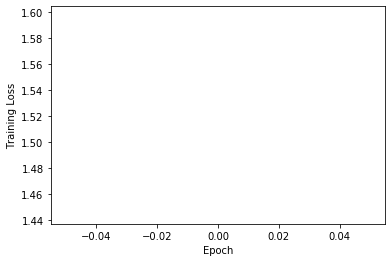

In [134]:
import matplotlib.pyplot as plt
plt.plot(loss_full)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png')

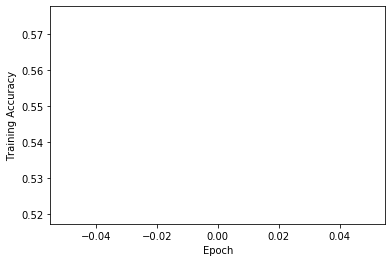

In [135]:
plt.plot(acc_full)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.savefig('train_acc.png')

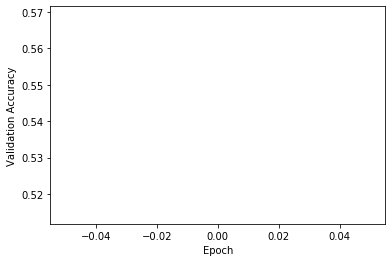

In [136]:
plt.plot(val_acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.savefig('val_acc.png')

# Evaluation

In [139]:
def test_accuracy(batch_size, x_test, y_test, sent_attn_model):
    acc = []
    test_length = len(x_test)
    for j in range(int(test_length/batch_size)):
        x,y = gen_batch(x_test,y_test,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [140]:
test_accuracy(batch_size, X_test_pad, y_test_tensor, sent_attn)

0.5625

In [60]:
# Predict only a single batch

x, y = gen_batch(X_test_pad,y_test_tensor,batch_size)

state_word = sent_attn.init_hidden_word()
state_sent = sent_attn.init_hidden_sent()
    
y_pred, state_sent = sent_attn(x, state_sent, state_word)
y_pred  # probability per label

tensor([[-0.2275, -3.4169, -2.2838, -4.1196, -4.0289, -5.0914, -4.4849, -5.2996,
         -6.0842, -5.8064, -6.3291, -6.2725, -6.0226, -6.9623],
        [-0.2012, -3.5427, -2.3386, -4.2325, -4.2303, -5.2892, -4.7342, -5.5522,
         -6.3163, -5.9588, -6.5203, -6.4650, -6.2449, -7.2799],
        [-0.2175, -3.4632, -2.3050, -4.1733, -4.0259, -5.1096, -4.6232, -5.5055,
         -6.1655, -5.8857, -6.4031, -6.3844, -6.1270, -7.1166],
        [-0.1903, -3.6379, -2.3731, -4.2567, -4.2564, -5.3318, -4.7867, -5.6472,
         -6.4332, -6.1202, -6.6738, -6.6105, -6.3810, -7.3687],
        [-0.2179, -3.4775, -2.3185, -4.0793, -4.0529, -5.1230, -4.5835, -5.4399,
         -6.1950, -5.8615, -6.3195, -6.3247, -6.0813, -7.0201],
        [-0.2118, -3.5120, -2.2839, -4.1932, -4.1864, -5.2037, -4.6829, -5.5380,
         -6.3105, -5.9990, -6.4613, -6.4698, -6.2174, -7.1968],
        [-0.2071, -3.5241, -2.3177, -4.2043, -4.1522, -5.2243, -4.7124, -5.5513,
         -6.2936, -5.9852, -6.4985, -6.4650, -6.2

In [67]:
max_index = y_pred.max(dim = 1)[1]  # use label with highest probability as prediction
max_index

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
y  # true labels

[tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([5.]),
 tensor([0.]),
 tensor([4.]),
 tensor([0.])]

In [64]:
y_pred.shape # torch.Size([batch_size=8, labels=14]) 

torch.Size([8, 14])